<a href="https://colab.research.google.com/github/azharm2412/PCD_Assignment03/blob/main/PCD_Assignment03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ASSIGNMENT 3 - SEGMENTASI DAN OPERASI MORFOLOGI**
*   **Nama:** Azhar Maulana
*   **NIM:** 24/533487/PA/22582
*   **Deskripsi Tugas:** Implementasi manual metode segmentasi *thresholding* dan operasi morfologi (Erosi, Dilasi, Opening, Closing) untuk membandingkan hasil segmentasi dengan dan tanpa *post-processing* morfologi.

---
**Catatan:** Jalankan semua cells secara berurutan dari atas ke bawah.

---



## **1. Setup**
Bagian ini berisi *import library* yang diperlukan (NumPy, Matplotlib, CV2, math) dan proses *mounting* Google Drive untuk mengakses file gambar.

In [1]:
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')
img_path = '/content/drive/MyDrive/PCD_Assignment03/2.jpeg'

# kernel untuk morfologi
kernel_3x3_square = np.ones((3, 3), np.uint8)
kernel_3x3_cross = np.array([[0, 1, 0], [1, 1, 1], [0,1,0]], np.uint8)
kernel_3x3_L = np.array([[1,0,0],[1,1,0],[1,1,1]],  np.uint8)

print("Setup selesai.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Setup selesai.


## **2. Fungsi Bantu**
Fungsi-fungsi ini dibuat untuk membantu menampilkan gambar, agar kode di bagian eksperimen nanti lebih rapi dan tidak berulang.

In [2]:
# menampilkan histogram
def show_histogram(hist_data):
  plt.figure(figsize=(7,7))
  plt.title("Histogram Gambar Grayscale")

  plt.bar(np.arange(256), hist_data, color='gray')

  plt.xlabel("Intensitas Piksel (0-255)")
  plt.ylabel("Jumlah Piksel")
  plt.xlim([0, 255]) # Pastikan sumbu X dari 0-255
  plt.show()

# menampilkan gambar
def show_img(title, img, cmap='gray', figsize =(7,7)):
  plt.figure(figsize=figsize)
  plt.imshow(img, cmap=cmap)
  plt.title(title, fontsize=14)
  plt.axis('off')
  plt.show()

# menampilkan perbandingan
def show_comparison(img_list, title_list, cmap='gray', fig_width_per_img=7):
  count = len(img_list)
  if count == 0:
    print("Tidak ada gambar untuk ditampilkan.")
    return

  plt.figure(figsize=(fig_width_per_img * count, 7))

  for i in range(count):
    plt.subplot(1, count, i+1)
    plt.imshow(img_list[i], cmap=cmap)
    plt.title(title_list[i], fontsize=14)
    plt.axis('off')

  plt.tight_layout(pad=1.0)
  plt.show()

## **3. Implementasi**
Bagian ini berisi semua implementasi fungsi utama (Segmentasi dan Morfologi) yang dibuat manual tanpa menggunakan *built-in function* dari OpenCV seperti `cv2.threshold`, `cv2.erode`, dll.

### **3.1 Fungsi Segmentasi**

In [3]:
def histogram(img):
    row, col = img.shape
    y = np.zeros(256, dtype=np.int64)
    for i in range(0,row):
        for j in range(0,col):
            y[int(img[i,j])] += 1
    return y


def regenerate_img(img, threshold):
    y = np.zeros_like(img, dtype=np.uint8)
    for i in range(0,img.shape[0]):
        for j in range(0,img.shape[1]):
            if img[i,j] >= threshold:
                y[i,j] = 255
    return y


def weight(h, s, e):
    w = 0
    for i in range(s, e):
        w += h[i]
    return w


def mean(h, s, e):
    m = 0
    w = weight(h, s, e)

    if w == 0:
        return 0

    for i in range(s, e):
        m += h[i] * i
    return m/float(w)


def variance(h, s, e):
    v = 0
    m = mean(h, s, e)
    w = weight(h, s, e)

    if w == 0:
        return 0

    for i in range(s, e):
        v += ((i - m) **2) * h[i]
    v /= w
    return v


def find_otsu_threshold(h):
    threshold_values = {}
    count = np.sum(h)

    for i in range(1, len(h)):

        vb = variance(h, 0, i)
        wb = weight(h, 0, i) / float(count)

        vf = variance(h, i, len(h))
        wf = weight(h, i, len(h)) / float(count)

        V2w = wb * (vb) + wf * (vf)

        if not math.isnan(V2w):
            threshold_values[i] = V2w

    return threshold_values


def get_optimal_threshold(threshold_values):
    min_V2w = min(threshold_values.values())
    optimal_threshold = [k for k, v in threshold_values.items() if v == min_V2w]

    return optimal_threshold[0]

### **3.2 Fungsi Morfologi**

In [4]:
# fungsi erosi
def erosion(img, kernel):
  img_rows, img_cols = img.shape
  kernel_rows, kernel_cols = kernel.shape

  pad = kernel_rows // 2

  output = np.zeros((img_rows, img_cols), dtype=np.uint8)

  for y in range(pad, img_rows - pad):
    for x in range(pad, img_cols - pad):
      roi = img[y - pad:y + pad + 1, x - pad:x + pad + 1]
      output[y, x] = np.min(roi[kernel == 1])

  return output

# fungsi dilasi
def dilation(img, kernel):
  img_rows, img_cols = img.shape
  kernel_rows, kernel_cols = kernel.shape

  pad = kernel_rows // 2

  output = np.zeros((img_rows, img_cols), dtype=np.uint8)

  for y in range(pad, img_rows - pad):
    for x in range(pad, img_cols - pad):
      roi = img[y - pad:y + pad + 1, x - pad:x + pad + 1]
      output[y, x] = np.max(roi[kernel == 1])

  return output

# fungsi opening
def opening(img, kernel):
  erosion_img = erosion(img, kernel)
  opening_img = dilation(erosion_img, kernel)
  return opening_img

# fungsi closing
def closing(img, kernel):
  dilation_img = dilation(img, kernel)
  closing_img = erosion(dilation_img, kernel)
  return closing_img


## **4. Eksperimen dan Hasil**

### **4.1 Memuat Gambar Asli**

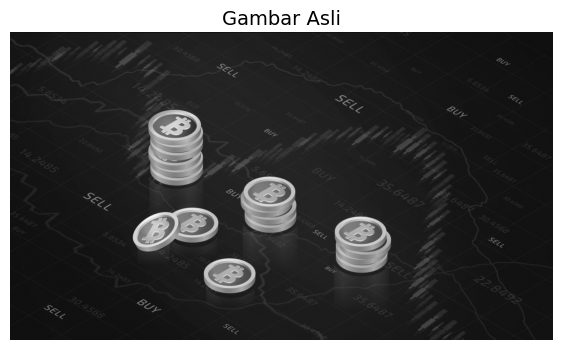

In [5]:
img_gray = cv2.imread(img_path, 0)
show_img("Gambar Asli", img_gray)

### **4.2 Skenario 1: Segmentasi (Tanpa Morfologi)**

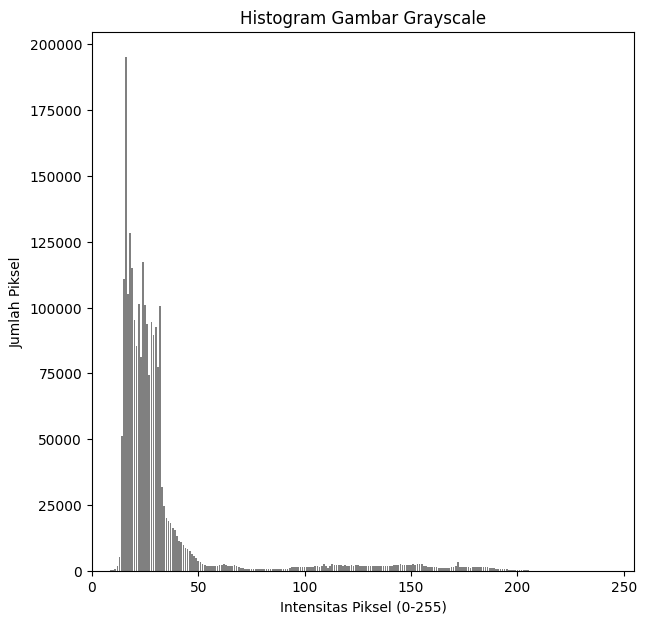

Optimal Threshold (Otsu) ditemukan pada: 83


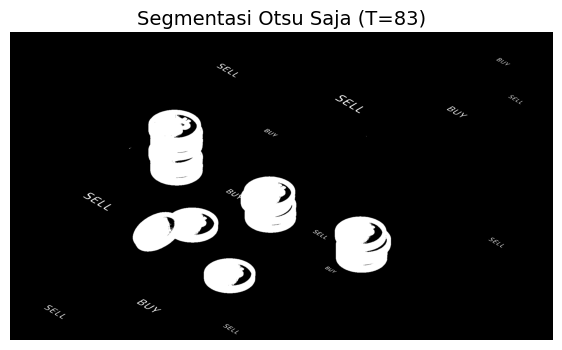

In [6]:
histogram_data = histogram(img_gray)
show_histogram(histogram_data)

# cari threshold optimal menggunakan otsu
threshold_values = find_otsu_threshold(histogram_data)
optimal_T = get_optimal_threshold(threshold_values)
print(f"Optimal Threshold (Otsu) ditemukan pada: {optimal_T}")

# threshold untuk segmentasi
img_segmented_only = regenerate_img(img_gray, optimal_T)

# menampilkan hasil
show_img(f"Segmentasi Otsu Saja (T={optimal_T})", img_segmented_only)

### **4.3 Skenario 2: Segmentasi + Morfologi**

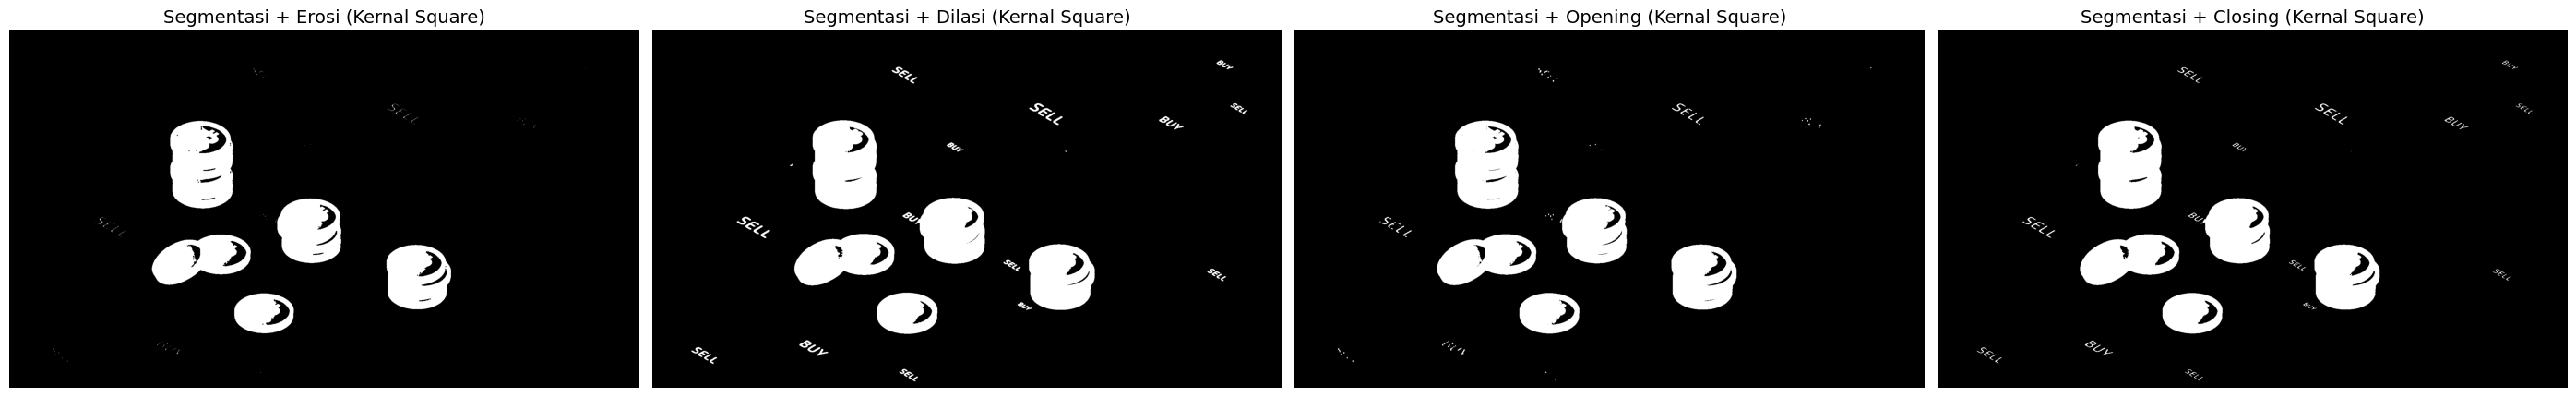

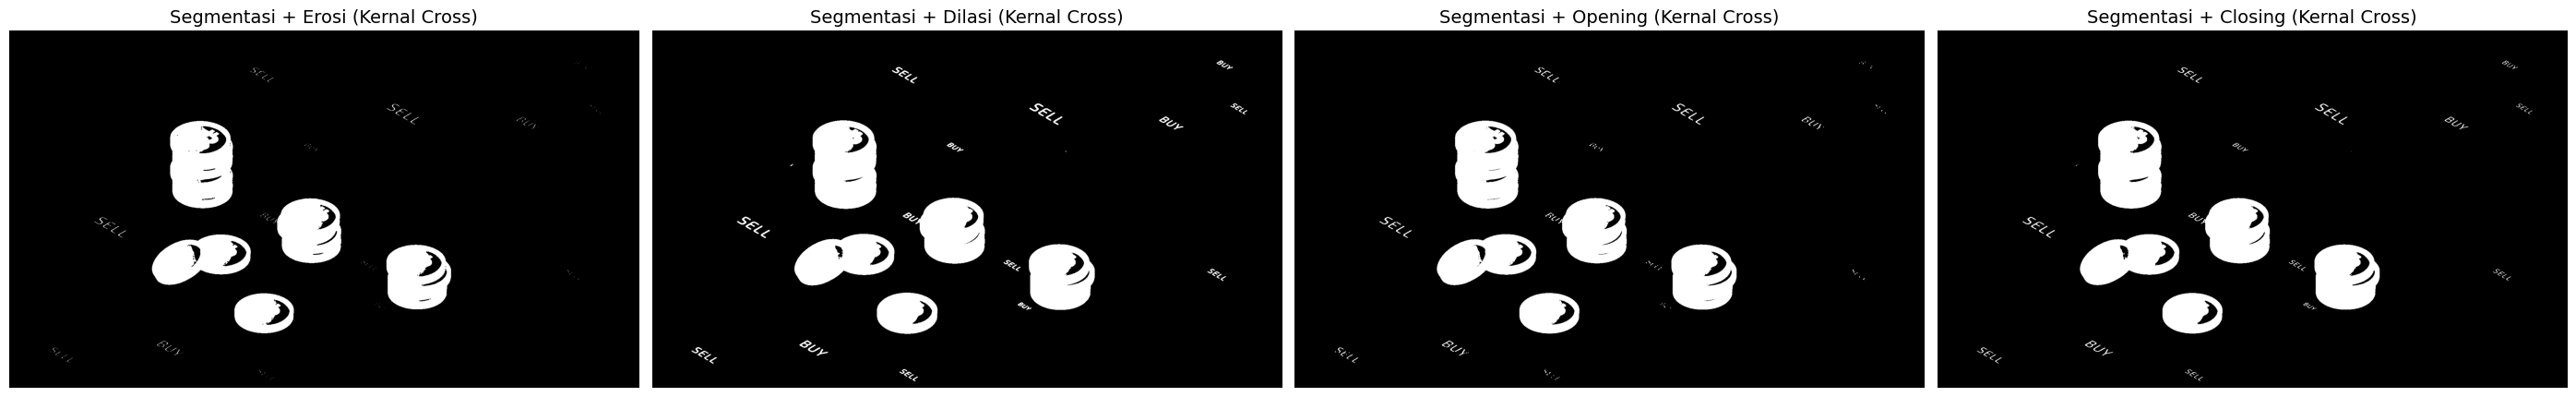

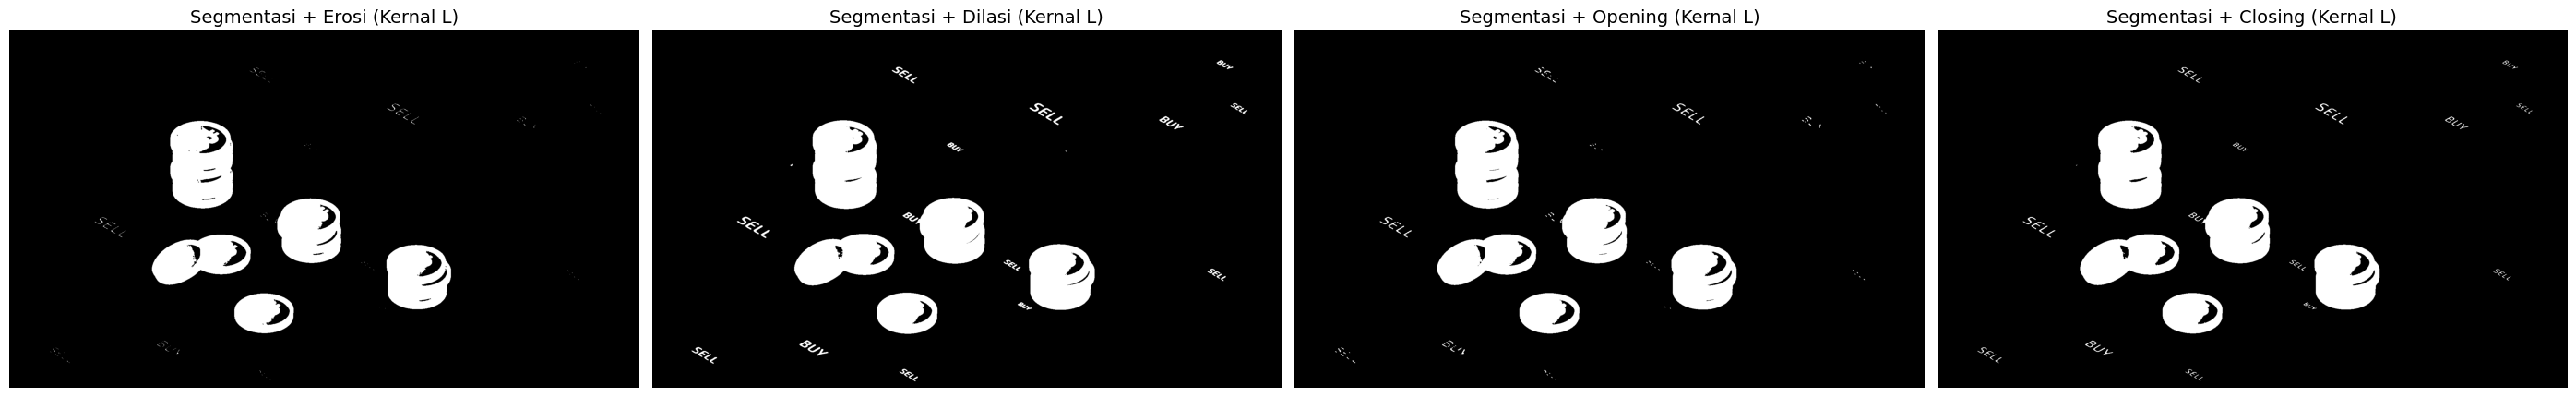

In [7]:
# hitung hasil untuk kernel square
img_after_erosion_square = erosion(img_segmented_only, kernel_3x3_square)
img_after_dilation_square = dilation(img_segmented_only, kernel_3x3_square)
img_after_opening_square = opening(img_segmented_only, kernel_3x3_square)
img_after_closing_square = closing(img_segmented_only, kernel_3x3_square)

# hitung hasil untuk kernal cross
img_after_erosion_cross = erosion(img_segmented_only, kernel_3x3_cross)
img_after_dilation_cross = dilation(img_segmented_only, kernel_3x3_cross)
img_after_opening_cross = opening(img_segmented_only, kernel_3x3_cross)
img_after_closing_cross = closing(img_segmented_only, kernel_3x3_cross)

# hitung hasil untuk kernel L
img_after_erosion_L = erosion(img_segmented_only, kernel_3x3_L)
img_after_dilation_L = dilation(img_segmented_only, kernel_3x3_L)
img_after_opening_L = opening(img_segmented_only, kernel_3x3_L)
img_after_closing_L = closing(img_segmented_only, kernel_3x3_L)

# menampilkan hasil perbandingan dengan kernel square
show_comparison(
    [img_after_erosion_square, img_after_dilation_square, img_after_opening_square, img_after_closing_square],
    ["Segmentasi + Erosi (Kernal Square)", "Segmentasi + Dilasi (Kernal Square)", "Segmentasi + Opening (Kernal Square)", "Segmentasi + Closing (Kernal Square)"]
)

# menampilkan hasil perbandingan dengan kernel cross
show_comparison(
    [img_after_erosion_cross, img_after_dilation_cross, img_after_opening_cross, img_after_closing_cross],
    ["Segmentasi + Erosi (Kernal Cross)", "Segmentasi + Dilasi (Kernal Cross)", "Segmentasi + Opening (Kernal Cross)", "Segmentasi + Closing (Kernal Cross)"]
)

# menampilkan hasil perbandingan dengan kernel L
show_comparison(
    [img_after_erosion_L, img_after_dilation_L, img_after_opening_L, img_after_closing_L],
    ["Segmentasi + Erosi (Kernal L)", "Segmentasi + Dilasi (Kernal L)", "Segmentasi + Opening (Kernal L)", "Segmentasi + Closing (Kernal L)"]
)

### **4.4 Perbandingan Akhir**

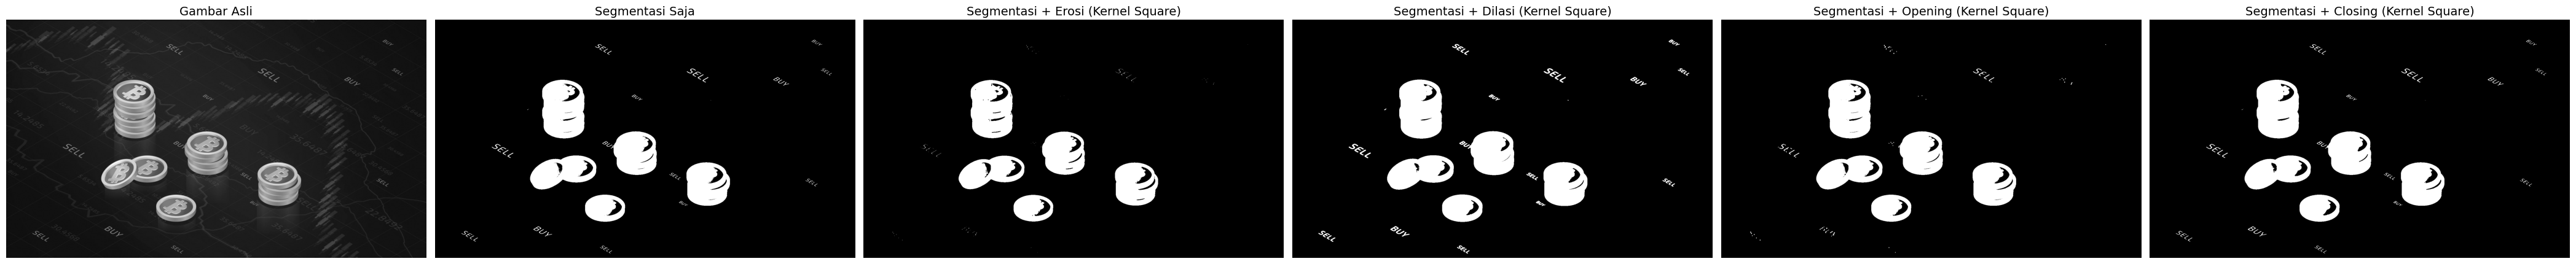

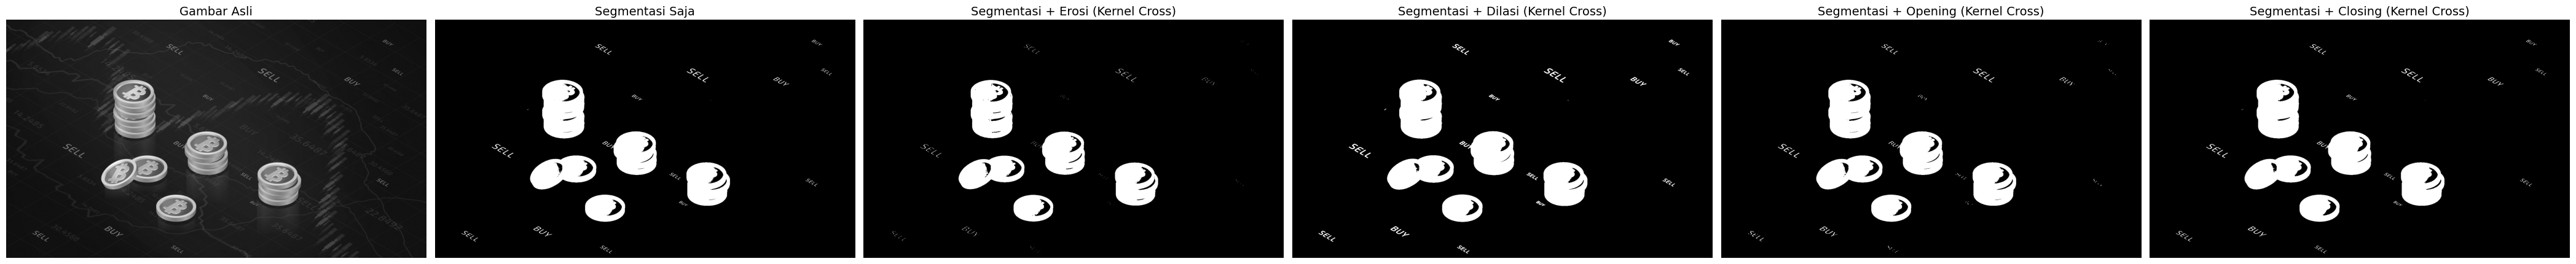

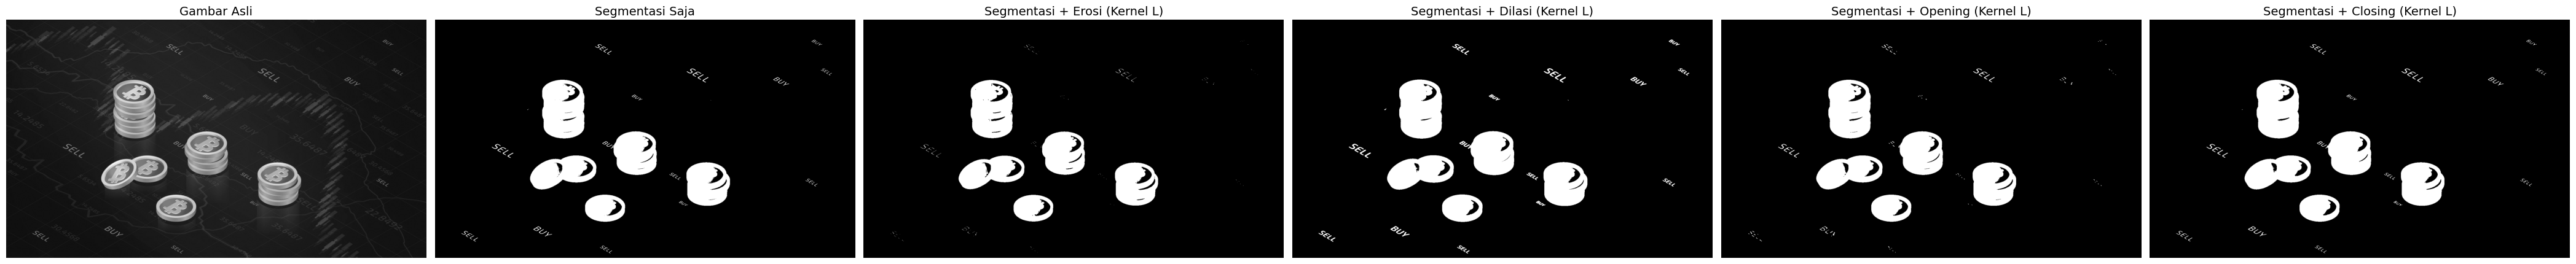

In [ ]:
show_comparison(
    [img_gray, img_segmented_only, img_after_erosion_square, img_after_dilation_square, img_after_opening_square, img_after_closing_square],
    ["Gambar Asli", "Segmentasi Saja", "Segmentasi + Erosi (Kernel Square)", "Segmentasi + Dilasi (Kernel Square)", "Segmentasi + Opening (Kernel Square)", "Segmentasi + Closing (Kernel Square)"]
)

show_comparison(
    [img_gray, img_segmented_only, img_after_erosion_cross, img_after_dilation_cross, img_after_opening_cross, img_after_closing_cross],
    ["Gambar Asli", "Segmentasi Saja", "Segmentasi + Erosi (Kernel Cross)", "Segmentasi + Dilasi (Kernel Cross)", "Segmentasi + Opening (Kernel Cross)", "Segmentasi + Closing (Kernel Cross)"]
)

show_comparison(
    [img_gray, img_segmented_only, img_after_erosion_L, img_after_dilation_L, img_after_opening_L, img_after_closing_L],
    ["Gambar Asli", "Segmentasi Saja", "Segmentasi + Erosi (Kernel L)", "Segmentasi + Dilasi (Kernel L)", "Segmentasi + Opening (Kernel L)", "Segmentasi + Closing (Kernel L)"]
)

## **5. Analisis dan Kesimpulan**

### **Skenario 1: Hanya Segmentasi tanpa Morfologi**
Di sini saya menggunakan metode Otsu untuk menentukan nilai ambang (threshold) yang optimal secara otomatis berdasarkan distribusi hitogram intensitas citra. Proses ini mencari nilai threshold yang meminimalkan variansi dalam kelas (*within-class variance*) dan sekaligus memaksimalkan variansi antar kelas (*between-class variance*). Hasil segmentasi menghasilkan citra biner yang memisahkan objek (foreground) dari latar belakang (background). Pada citra ini, Otsu menemukan nilai ambang optimal **T = 83**, yang berarti seluruh piksel dengan intensitas ≥ 83 dianggap sebagai bagian objek (putih), sedangkan piksel dengan nilai < 83 dianggap sebagai latar belakang (hitam). Hasil segmentasi menunjukkan bahwa objek utama berupa tumpukan koin dan tulisan “BUY” serta “SELL” berhasil dipisahkan dengan baik dari latar belakang. Hal ini menunjukkan bahwa metode Otsu mampu mendeteksi semua area dengan intensitas tinggi, termasuk elemen teks yang memang memiliki tingkat kecerahan di atas ambang batas (T=83). Secara matematis, hal ini menunjukkan keberhasilan Otsu dalam menyeleksi kelas piksel terang sebagai foreground. Metode Otsu ini juga berhasil mendeteksi tulisan "BUY" dan "SELL" sebagai objek penting dalam gambar.

### **Skenario 2: Segmentasi + Morfologi**
Pada skenario kedua, hasil segmentasi Otsu dengan nilai ambang **T=83** diproses lebih lanjut menggunakan operasi morfologi untuk meningkatkan kualitas segmentasi. Operasi morfologi yang digunakan meliputi erosi, dilasi, opening, dan closing. Percobaan dilakukan dengan tiga bentuk kernel yang berbeda, yaitu **square (3x3)**, **cross (3x3)**, dan **L-shape (3x3)**.

Secara umum, hasil perbandingan menunjukkan bahwa operasi morfologi memberikan pengaruh yang signifikan terhadap kualitas hasil segmentasi. ada hasil segmentasi Otsu saja, objek utama berupa tumpukan koin dan tulisan “BUY/SELL” sudah tampak jelas terpisah dari latar belakang. Namun, batas antara koin dan teks masih tampak tajam dan kasar, serta terdapat beberapa area kecil di sekitar objek yang kurang bersih. Setelah diterapkan operasi morfologi, citra hasil menjadi lebih terstruktur dan halus, dengan perbedaan efek tergantung pada jenis operasinya.

#### **1. Erosi**
Pada tahap erosi, area terang sedikit menyusut. Efek ini terlihat pada tulisan "BUY" atau "SELL" yang menjadi lebih tipis bahkan hilang. Hal ini terjadi karena erosi bekerja dengan mengganti nilai setiap piksel dengan nilai minimum dari area sekitarnya yang dicakup oleh kernel. Dengan kata lain, piksel putih (nilai tinggi) hanya akan tetap bertahan jika seluruh piksel di area kernel juga bernilai putih. Apabila terdapat satu saja piksel gelap (hitam) di dalam area kernel, maka piksel pusat akan berubah menjadi hitam.

Efek dari proses ini terlihat jelas pada hasil citra: bagian tepi objek utama seperti tumpukan koin menjadi sedikit lebih tipis, sementara tulisan “BUY” dan “SELL” tampak menurun ketebalannya, bahkan sebagian huruf kecil hilang sama sekali. Hal ini terjadi karena bentuk huruf yang tipis tidak mampu mempertahankan semua piksel putih di dalam area kernel sehingga terhapus oleh operasi erosi.

#### **2. Dilasi**
Operasi dilasi merupakan kebalikan dari erosi. Jika erosi menghilangkan piksel terang di tepi objek, maka dilasi justru menambahkan piksel terang baru di sekitar area objek. Secara matematis, dilasi bekerja dengan menggantikan nilai setiap piksel dengan nilai maksimum dari area sekitarnya yang dicakup oleh kernel. Artinya, apabila ada satu saja piksel putih (nilai tinggi) dalam jangkauan kernel, maka piksel pusat juga akan menjadi putih.

Efek dari proses ini terlihat jelas pada hasil citra: objek tampak sedikit membesar dan lebih tebal dibandingkan hasil segmentasi awal. Tulisan “BUY” serta “SELL” juga terlihat lebih tebal. Hal ini menunjukkan bahwa operasi dilasi tidak hanya memperbesar area terang, tetapi juga dapat menyambungkan komponen foreground yang sebelumnya terpisah oleh jarak kecil berwarna gelap.

#### **3. Opening**
Operasi opening merupakan kombinasi dari dua tahapan, yaitu erosi yang diikuti oleh dilasi. Tujuan utama dari opening adalah untuk menghilangkan noise kecil atau objek-objek tipis yang tidak diinginkan, sambil tetap mempertahankan bentuk utama dari objek besar di dalam citra. Dengan kata lain, opening bekerja sebagai proses penyaringan bentuk: erosi membersihkan area kecil yang tidak stabil, kemudian dilasi mengembalikan ukuran objek agar tidak terlalu menyusut akibat tahap pertama.

Pada hasil citra, efek opening terlihat jelas pada area sekitar teks dan background. Tulisan “BUY” dan “SELL” yang hilang akibat erosi, muncul kembali setelah dilakukan proses dilasi. Walaupun hasilnya tampak sedikit menipis dibandingkan hasil dilasi saja, tetapi tetap terbaca dengan jelas.

#### **4. Closing**
Operasi closing merupakan kebalikan dari opening, yaitu dilasi yang diikuti oleh erosi. Tujuan utama closing adalah untuk menutup lubang-lubang kecil di dalam objek foreground dan menyatukan bagian-bagian terang yang hampir terpisah sehingga menghasilkan objek yang lebih padat dan utuh secara visual. Secara matematis, dilasi pertama-tama memperluas area terang, kemudian erosi berikutnya mengembalikan bentuk objek ke ukuran semula, tetapi dengan lubang yang telah tertutup.

Pada hasil citra, efek closing terlihat jelas pada bagian koin dan teks “BUY” serta “SELL”. Area putih pada koin menjadi lebih solid, dan celah-celah kecil di antara huruf-huruf teks tampak menutup rapat. Bentuk koin terlihat lebih menyatu, terutama pada bagian tepi yang sebelumnya tampak tidak rata akibat segmentasi awal. Closing juga memperhalus area yang sebelumnya terpecah akibat erosi atau noise, menjadikannya lebih kompak dan konsisten.

#### **Perbandingan Penggunaan Jenis Kernel**
Dalam percobaan ini digunakan tiga jenis kernel morfologi, yaitu square (3×3), cross (3×3), dan L-shape (3×3). Ketiganya memiliki karakteristik dan arah pengaruh yang berbeda terhadap hasil citra sehingga memberikan variasi efek pada bentuk dan kehalusan hasil segmentasi setelah operasi morfologi dilakukan. Tidak terlalu terlihat jelas pengaruh dari masing-masing kernel, tetapi secara keseluruhan, kernel square (3x3) memberikan hasil terbaik karena kernel ini memiliki nilai 1 pada seluruh posisinya sehingga memberikan pengaruh yang merata ke semua arah baik horizontal, vertikal, maupun diagonal.

### **Kesimpulan Akhir**
Berdasarkan hasil seluruh percobaan yang telah dilakukan, dapat disimpulkan bahwa kombinasi antara segmentasi metode Otsu dan operasi morfologi memberikan peningkatan kualitas citra yang signifikan. Metode segmentasi Otsu dengan ambang T = 83 berhasil memisahkan objek utama dari latar belakang dengan cukup baik, tetapi masih kurang halus. Penerapan operasi morfologi terbukti mampu menyempurnakan hasil tersebut. Penerapan operasi morfologi terbukti mampu menyempurnakan hasil tersebut. Erosi menghilangkan bintik-bintik kecil, dilasi menutup celah antar piksel terang, opening membersihkan noise tanpa merusak bentuk objek, dan closing memperkuat struktur dengan menutup lubang kecil di dalam objek.

Walaupun tidak terlalu jelas perbedaannya, tetapi dari ketiga bentuk kernel yang digunakan, kernel square (3x3) memberikan hasil yang paling seimbang. Secara keseluruhan, kombinasi segmentansi Otsu dan operasi morfologi, khususnya opening dan closing menggunakan kernel square menghasilkan citra yang paling baik.